### Develop the Merging Algorithm
1. Load the Data: Use pd.read_csv to load the bounding box coordinates from the CSV files you've created.
2. Data Preprocessing: Normalize the bounding box coordinates if necessary, ensuring they're in a consistent format and scale.
3. Clustering Algorithm: Implement a clustering algorithm such as DBSCAN to group closely related bounding boxes based on their spatial relationships. Use the centroids or corners of the bounding boxes as features for clustering.
4. Merge Bounding Boxes: For each cluster of bounding boxes identified by the clustering algorithm, calculate the minimum and maximum coordinates to find the merged bounding box that encompasses all boxes within the cluster.


# Exploratory Data Analysis

In [171]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as patches
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

# Load the data from both CSV files
list_a_path = r"D:\bounding_box_merger\data\processed\csv\list_a.csv"
list_b_path = r"D:\bounding_box_merger\data\processed\csv\list_b.csv"

list_a_df = pd.read_csv(list_a_path)
list_b_df = pd.read_csv(list_b_path)

# First, let's combine List A and List B into a single DataFrame for easier processing.
combined_df = pd.concat([list_a_df, list_b_df], ignore_index=True)

# Ensure all coordinates are integers
combined_df[['x1', 'y1', 'x2', 'y2']] = combined_df[['x1', 'y1', 'x2', 'y2']].astype(int)

# Check the data types and first few rows to confirm normalization
combined_df.dtypes, combined_df.head(), combined_df.shape


(x1    int32
 y1    int32
 x2    int32
 y2    int32
 dtype: object,
      x1    y1    x2    y2
 0  2929  1727  3056  1801
 1   714  3826   784  4033
 2  1970  2461  2028  2654
 3  5690  2156  5801  2247
 4  4026  3674  4138  3781,
 (5006, 4))

# Using DBSCAN for Clustering the dataset

Here we will use general DBSCAN with no hyperparameter tuning

In [172]:
# Step 1: Calculate center points of bounding boxes
combined_df['center_x'] = (combined_df['x1'] + combined_df['x2']) / 2
combined_df['center_y'] = (combined_df['y1'] + combined_df['y2']) / 2

# Features for clustering: center points
features = combined_df[['center_x', 'center_y']]

# Standardize features to have mean=0 and variance=1, improving DBSCAN performance
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 2: Apply DBSCAN clustering
# eps and min_samples are chosen based on exploratory analysis and may need adjustment
dbscan = DBSCAN()
clusters = dbscan.fit_predict(features_scaled)

# Add cluster labels to the DataFrame
combined_df['cluster'] = clusters

# Step 3: Merge Bounding Boxes within Clusters
# For each cluster, calculate the minimum enclosing bounding box
merged_boxes = []
for cluster in set(clusters):
    if cluster == -1:  # Skip noise points
        continue
    cluster_boxes = combined_df[combined_df['cluster'] == cluster]
    min_x = cluster_boxes['x1'].min()
    min_y = cluster_boxes['y1'].min()
    max_x = cluster_boxes['x2'].max()
    max_y = cluster_boxes['y2'].max()
    merged_boxes.append([min_x, min_y, max_x, max_y, cluster])

# Create a DataFrame for merged bounding boxes
merged_boxes_df = pd.DataFrame(merged_boxes, columns=['x1', 'y1', 'x2', 'y2', 'cluster'])

# Save to CSV
merged_boxes_csv_path = r"D:\bounding_box_merger\data\processed\csv\merged_boxes_no_tunning.csv"
merged_boxes_df.to_csv(merged_boxes_csv_path, index=False)
print(f"Merged bounding boxes saved to {merged_boxes_csv_path}")

# Display the first few merged bounding boxes
merged_boxes_df


Merged bounding boxes saved to D:\bounding_box_merger\data\processed\csv\merged_boxes_no_tunning.csv


,x1,y1,x2,y2,cluster
0,163,19,8030,5458,0
1,14022,360,5055,3944,1


Evaluation for DBSCAN Model

In [173]:
score_cal = calinski_harabasz_score(features, clusters)
score_dav = davies_bouldin_score(features, clusters)
print(f"Calinski-Harabasz Score: {score_cal}")
print(f"Davies-Bouldin Score: {score_dav}")

Calinski-Harabasz Score: 358.0713084852096
Davies-Bouldin Score: 1.2976953602227432


Lets calcualets the eps and min_samples

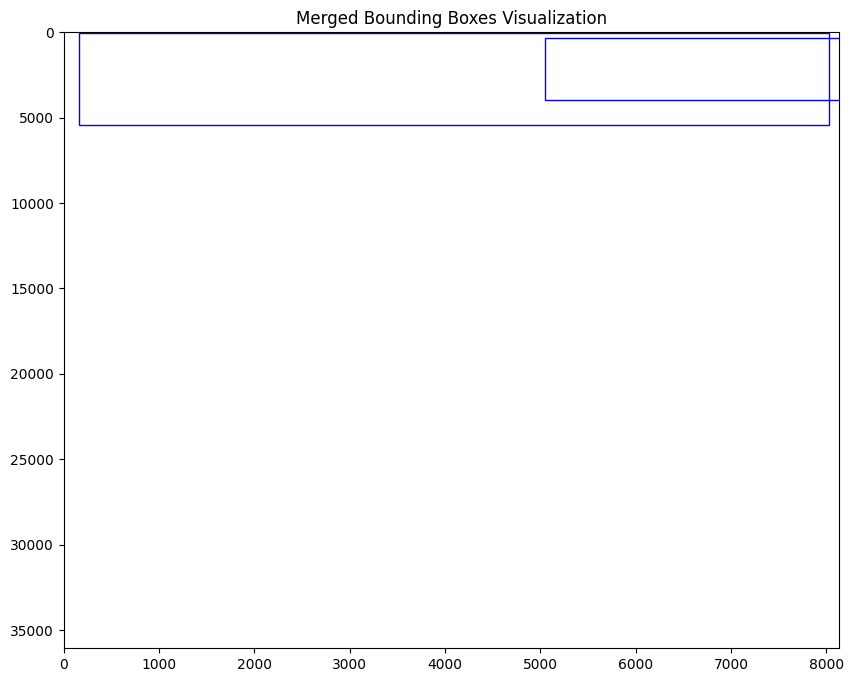

In [174]:
fig, ax = plt.subplots(figsize=(10, 8))

# Assuming a maximum canvas size based on the maximum coordinates observed
canvas_width = max(combined_df['x2'].max(), merged_boxes_df['x2'].max()) + 100
canvas_height = max(combined_df['y2'].max(), merged_boxes_df['y2'].max()) + 100

ax.set_xlim(0, canvas_width)
ax.set_ylim(0, canvas_height)
ax.invert_yaxis()  # Invert the y-axis to match image coordinates
ax.set_title('Merged Bounding Boxes Visualization')

for _, row in merged_boxes_df.iterrows():
    rect = patches.Rectangle((row['x1'], row['y1']), row['x2']-row['x1'], row['y2']-row['y1'], linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [175]:

#iteratite the best approach for eps
for eps in np.arange(0.1, 1.0, 0.1):
    for min_samples in range(1, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(features_scaled)
        print(f"EPS: {eps}, Min_samples: {min_samples}, Clusters: {len(set(clusters)) - (1 if -1 in clusters else 0)}")


EPS: 0.1, Min_samples: 1, Clusters: 197
EPS: 0.1, Min_samples: 2, Clusters: 77
EPS: 0.1, Min_samples: 3, Clusters: 35
EPS: 0.1, Min_samples: 4, Clusters: 25
EPS: 0.1, Min_samples: 5, Clusters: 24
EPS: 0.1, Min_samples: 6, Clusters: 21
EPS: 0.1, Min_samples: 7, Clusters: 23
EPS: 0.1, Min_samples: 8, Clusters: 27
EPS: 0.1, Min_samples: 9, Clusters: 23


EPS: 0.2, Min_samples: 1, Clusters: 39
EPS: 0.2, Min_samples: 2, Clusters: 20
EPS: 0.2, Min_samples: 3, Clusters: 12
EPS: 0.2, Min_samples: 4, Clusters: 9
EPS: 0.2, Min_samples: 5, Clusters: 6
EPS: 0.2, Min_samples: 6, Clusters: 4
EPS: 0.2, Min_samples: 7, Clusters: 4
EPS: 0.2, Min_samples: 8, Clusters: 6
EPS: 0.2, Min_samples: 9, Clusters: 3
EPS: 0.30000000000000004, Min_samples: 1, Clusters: 16
EPS: 0.30000000000000004, Min_samples: 2, Clusters: 8
EPS: 0.30000000000000004, Min_samples: 3, Clusters: 4
EPS: 0.30000000000000004, Min_samples: 4, Clusters: 6
EPS: 0.30000000000000004, Min_samples: 5, Clusters: 4
EPS: 0.30000000000000004, Min_samples: 6, Clusters: 3
EPS: 0.30000000000000004, Min_samples: 7, Clusters: 3
EPS: 0.30000000000000004, Min_samples: 8, Clusters: 2
EPS: 0.30000000000000004, Min_samples: 9, Clusters: 3
EPS: 0.4, Min_samples: 1, Clusters: 9
EPS: 0.4, Min_samples: 2, Clusters: 5
EPS: 0.4, Min_samples: 3, Clusters: 3
EPS: 0.4, Min_samples: 4, Clusters: 2
EPS: 0.4, Min_sa

### Recommendations:- 
* Intermediate eps Values: Configurations with eps around 0.3 to 0.6 show a promising balance, reducing the number of clusters compared to very low eps values without collapsing everything into one or two clusters. Within this range:
* For eps = 0.3, min_samples = 2 to 4 results in a moderate number of clusters (between 8 and 4), which might indicate a balanced approach.
* For eps = 0.4 and eps = 0.5, min_samples = 2 and above tend to offer a low but potentially meaningful number of clusters with minimal noise.

So we will choose eps with 0.6 and min_samples with 3

In [176]:
# Step 1: Calculate center points of bounding boxes
combined_df['center_x'] = (combined_df['x1'] + combined_df['x2']) / 2
combined_df['center_y'] = (combined_df['y1'] + combined_df['y2']) / 2

# Features for clustering: center points
features = combined_df[['center_x', 'center_y']]

# Standardize features to have mean=0 and variance=1, improving DBSCAN performance
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 2: Apply DBSCAN clustering
# eps and min_samples are chosen based on exploratory analysis and may need adjustment
dbscan = DBSCAN(eps = 0.6, min_samples=3)
clusters = dbscan.fit_predict(features_scaled)

# Add cluster labels to the DataFrame
combined_df['cluster'] = clusters

# Step 3: Merge Bounding Boxes within Clusters
# For each cluster, calculate the minimum enclosing bounding box
merged_boxes = []
for cluster in set(clusters):
    if cluster == -1:  # Skip noise points
        continue
    cluster_boxes = combined_df[combined_df['cluster'] == cluster]
    min_x = cluster_boxes['x1'].min()
    min_y = cluster_boxes['y1'].min()
    max_x = cluster_boxes['x2'].max()
    max_y = cluster_boxes['y2'].max()
    merged_boxes.append([min_x, min_y, max_x, max_y, cluster])

# Create a DataFrame for merged bounding boxes
merged_boxes_df = pd.DataFrame(merged_boxes, columns=['x1', 'y1', 'x2', 'y2', 'cluster'])
  # Display the first few merged bounding boxes
# Save to CSV
merged_boxes_csv_path = r"D:\bounding_box_merger\data\processed\csv\merged_boxes.csv"
merged_boxes_df.to_csv(merged_boxes_csv_path, index=False)
print(f"Merged bounding boxes saved to {merged_boxes_csv_path}")

merged_boxes_df


Merged bounding boxes saved to D:\bounding_box_merger\data\processed\csv\merged_boxes.csv


,x1,y1,x2,y2,cluster
0,163,19,8030,5458,0
1,14022,244,5055,4447,1


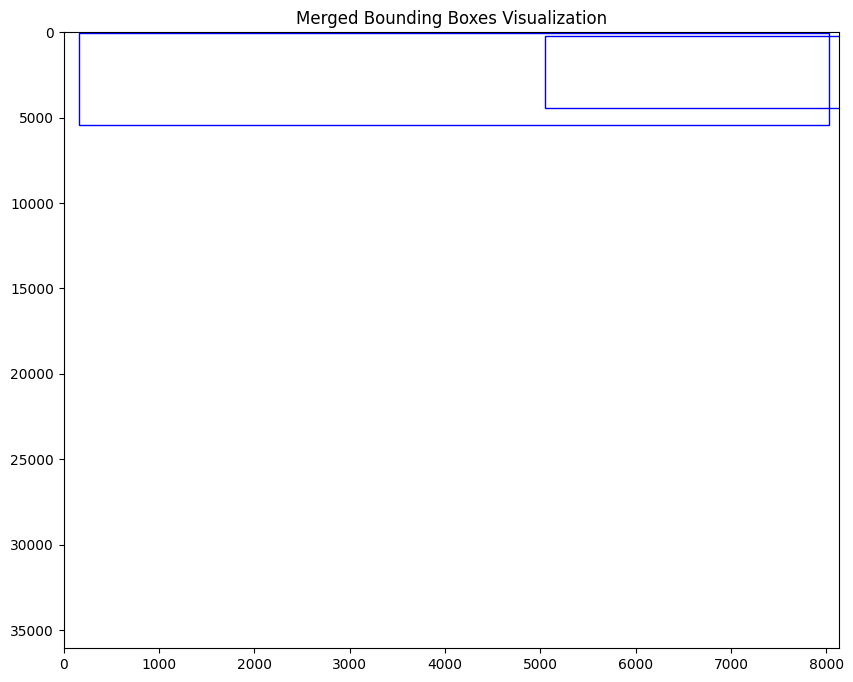

In [177]:

# Set up a blank canvas for visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Assuming a maximum canvas size based on the maximum coordinates observed
canvas_width = max(combined_df['x2'].max(), merged_boxes_df['x2'].max()) + 100
canvas_height = max(combined_df['y2'].max(), merged_boxes_df['y2'].max()) + 100

ax.set_xlim(0, canvas_width)
ax.set_ylim(0, canvas_height)
ax.invert_yaxis()  # Invert the y-axis to match image coordinates
ax.set_title('Merged Bounding Boxes Visualization')

# Plot each merged bounding box
for _, row in merged_boxes_df.iterrows():
    rect = patches.Rectangle((row['x1'], row['y1']), row['x2']-row['x1'], row['y2']-row['y1'], linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

plt.show()

# Evaluation


In [178]:
score_cal = calinski_harabasz_score(features, clusters)
score_dav = davies_bouldin_score(features, clusters)
print(f"Calinski-Harabasz Score: {score_cal}")
print(f"Davies-Bouldin Score: {score_dav}")

Calinski-Harabasz Score: 379.0938313877749
Davies-Bouldin Score: 1.0086454327904484
